In [36]:
import pandas as pd

DATA_PATH = 'dataframes/temperature.xlsx'

df       = pd.read_excel(DATA_PATH, index_col='Date', parse_dates=True)
# df.index = pd.to_datetime(df.index)
df.head(3)

,Daily minimum temperatures
Date,
1981-01-01 00:00:00,20.7
1981-02-01 00:00:00,17.9
1981-03-01 00:00:00,18.8


In [37]:
df.index.min(), df.index.max()

('1/13/1981', '9/30/1990')

In [38]:
df.rename(columns={'Daily minimum temperatures': 'Temp'}, inplace=True)
df.head(2)

,Temp
Date,
1981-01-01 00:00:00,20.7
1981-02-01 00:00:00,17.9


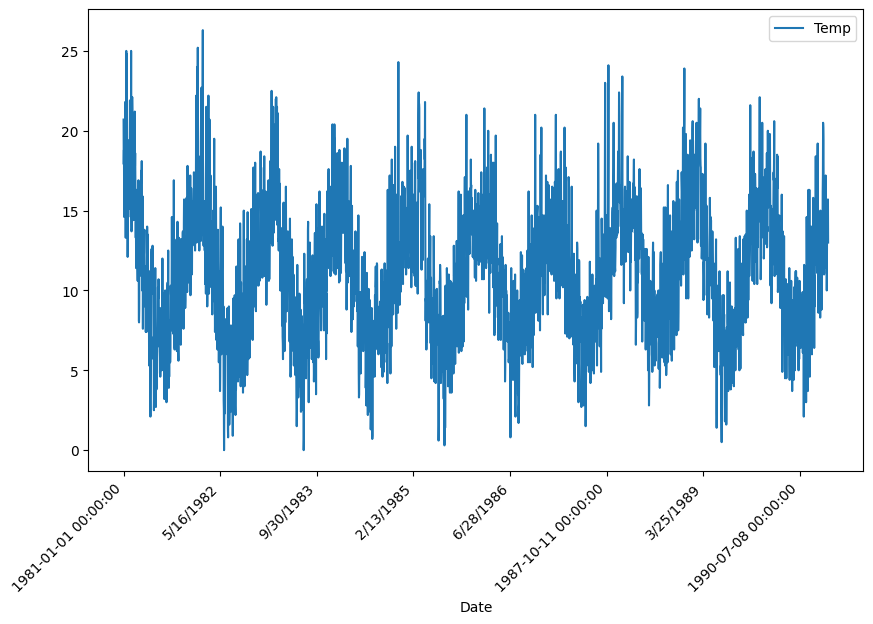

In [39]:
import matplotlib.pyplot as plt

ax = df.plot(figsize=(10, 6))
plt.xticks(rotation=45, ha='right')
plt.show()

<Figure size 800x600 with 0 Axes>

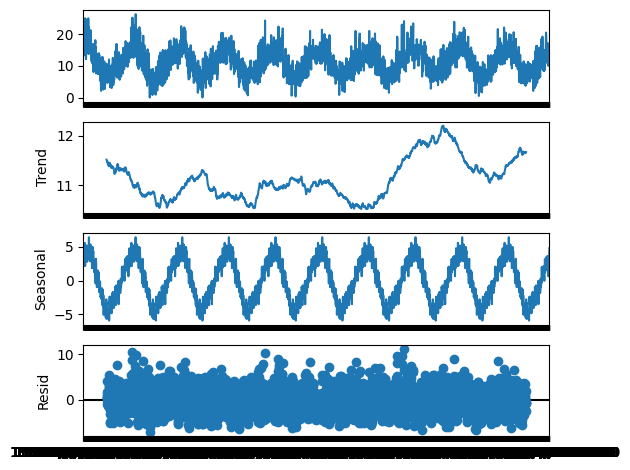

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df, model="add", period=365)

fig = plt.figure(figsize=(8, 6))  
fig = decomp.plot()

In [41]:
'''Uma série temporal estacionária é aquela cujas propriedades estatísticas (média, variância, etc.)
não dependem do tempo em que a série é observada. Se p value > 0.05, a série é não estacionária.'''

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Temp'].dropna())
print(f'ADF test  -> {result[0]}\np value   -> {result[1]}\np value % -> {(result[1]*100).round(2)}%')
print(result) # The method 'adfuller' returns [adf, pvalue, usedlag, nobs, criticial values, icbest, resstore]

ADF test  -> -4.444652847181708
p value   -> 0.00024723724658534517
p value % -> 0.02%
(-4.444652847181708, 0.00024723724658534517, 20, 3626, {'1%': -3.432154725699155, '5%': -2.8623374271161723, '10%': -2.567194482813802}, 16626.55846460068)


In [42]:
from pmdarima.arima import auto_arima

fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=6.06 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=20190.243, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=19023.926, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=2.80 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=20059.581, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=18557.981, Time=1.46 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=5.86 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=2.43 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=18671.439, Time=0.43 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=18307.460, Time=0.82 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=18782.577, Time=0.49 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=8.07 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=4.14 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=18162.316, Time=1.08 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=18652.035, Ti

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model   = SARIMAX(df,order=(3,1,0))
sarimax = model.fit()

c:\Users\jeanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
print(sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3647
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8571.463
Date:                Thu, 28 Mar 2024   AIC                          17150.926
Time:                        12:26:38   BIC                          17175.732
Sample:                             0   HQIC                         17159.760
                               - 3647                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2821      0.015    -19.323      0.000      -0.311      -0.253
ar.L2         -0.3094      0.015    -20.331      0.000      -0.339      -0.280
ar.L3         -0.1989      0.016    -12.413      0.0

In [45]:
predict      = sarimax.get_prediction(start=-60)
predict_mean = predict.predicted_mean
predict_mean[0]

C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\2729718599.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_mean[0]


15.003050577681526

In [46]:
conf_interval = predict.conf_int()
limit_min     = conf_interval.iloc[:,0]
limit_max     = conf_interval.iloc[:,1]

limit_min[0], limit_max[0]

C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\4132576603.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  limit_min[0], limit_max[0]


(10.02597083825659, 19.98013031710646)

In [47]:
import numpy as np

dates_pred = np.asarray(predict_mean.index)
dates      = np.asarray(df.index)

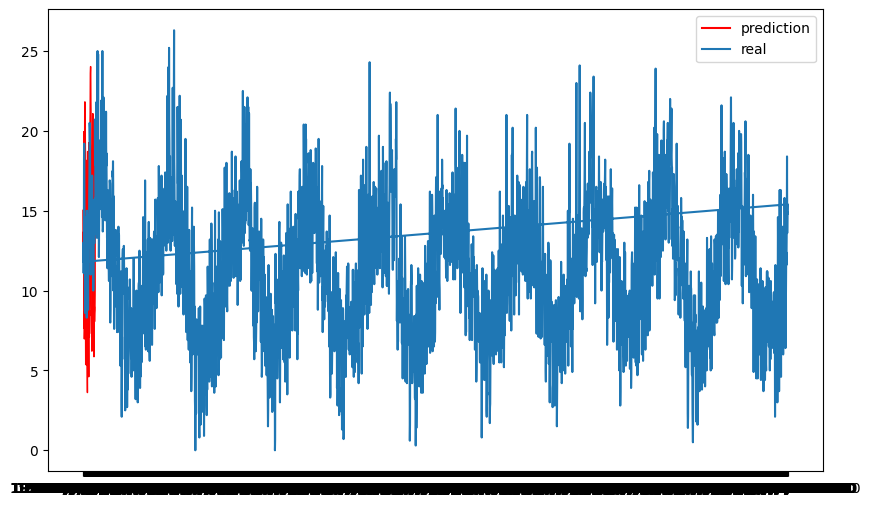

In [48]:
plt.figure(figsize=(10,6))
plt.plot(dates_pred,predict_mean.values,color='red',label='prediction')
plt.fill_between(dates_pred, limit_min, limit_max, color='red')
plt.plot(dates, df.values, label='real')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(f'RMSE -> {sqrt(mean_squared_error(df[-60:].values, predict_mean.values))}')

RMSE -> 2.4626597665970498


In [50]:
df.index.min(), df.index.max()

('1/13/1981', '9/30/1990')

In [51]:
from xgboost import XGBRegressor

train      = df.loc[df.index <= '1988-12-31']
validation = df.loc[df.index > '1989-01-01']

train.shape, validation.shape

((1900, 1), (1747, 1))

In [52]:
train.index.min(), train.index.max(), validation.index.min(), validation.index.max()

('1/13/1981', '1988-12-12 00:00:00', '1989-01-01 00:00:00', '9/30/1990')

In [53]:
train['target'] = train['Temp'].shift(-1)
train.dropna(inplace=True)

validation['target'] = validation['Temp'].shift(-1)
validation.dropna(inplace=True)

C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\4199549766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train['Temp'].shift(-1)
C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\4199549766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\4199549766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [54]:
X_train = train.loc[:, ['Temp']].values
y_train = train.loc[:, ['target']].values

X_validation = validation.loc[:, ['Temp']].values
y_validation = validation.loc[:, ['target']].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((1899, 1), (1899, 1), (1746, 1), (1746, 1))

In [55]:
model_xgba = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
model_xgba.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
validation.iloc[0]

Temp      18.3
target    22.0
Name: 2/13/1981, dtype: float64

In [57]:
validation['pred'] = predict
validation

C:\Users\jeanl\AppData\Local\Temp\ipykernel_5256\3984984965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['pred'] = predict


,Temp,target,pred
Date,,,
2/13/1981,18.3,22.0,<statsmodels.tsa.statespace.mlemodel.Predictio...
2/14/1981,22.0,22.1,<statsmodels.tsa.statespace.mlemodel.Predictio...
2/15/1981,22.1,21.2,<statsmodels.tsa.statespace.mlemodel.Predictio...
2/16/1981,21.2,18.4,<statsmodels.tsa.statespace.mlemodel.Predictio...
2/17/1981,18.4,16.6,<statsmodels.tsa.statespace.mlemodel.Predictio...
...,...,...,...
1990-07-12 00:00:00,19.4,15.5,<statsmodels.tsa.statespace.mlemodel.Predictio...
1990-08-12 00:00:00,15.5,14.1,<statsmodels.tsa.statespace.mlemodel.Predictio...
1990-09-12 00:00:00,14.1,11.0,<statsmodels.tsa.statespace.mlemodel.Predictio...


In [58]:
print(f'MSE -> {mean_squared_error(X_validation, predict)}')

InvalidParameterError: The 'y_pred' parameter of mean_squared_error must be an array-like. Got <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x000002378C2AC790> instead.